# Gemini 3 Pro Results Analysis

Analysis of cross-turn language switching experiments on Gemini 3 Pro.

In [1]:
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

RESULTS_DIR = '../results/gemini-3-pro'

## 1. Load All Results

In [2]:
def load_evaluated_results(results_dir):
    """Load all evaluated results into a DataFrame."""
    records = []
    
    for eval_file in glob.glob(f'{results_dir}/**/evaluated_*.jsonl', recursive=True):
        path_parts = eval_file.split('/')
        condition = [p for p in path_parts if p in ['baseline', 'codeswitching', 'codeswitching_reverse', 
                                                      'full_translation', 'distractor', 'distractor_multi']][0]
        
        with open(eval_file) as f:
            for line in f:
                d = json.loads(line)
                eval_info = d.get('evaluation', {})
                
                # Detect language from question_id suffix (e.g., 674552683acc22154b07a598_de -> de)
                qid = d['question_id']
                if '_ar' in qid: lang = 'ar'
                elif '_de' in qid: lang = 'de'
                elif '_es' in qid: lang = 'es'
                elif '_zh' in qid: lang = 'zh'
                else: lang = None  # baseline has no suffix
                
                records.append({
                    'question_id': qid,
                    'axis': d['axis'],
                    'condition': condition,
                    'language': lang,
                    'response': d.get('response', ''),
                    'response_len': len(d.get('response', '') or ''),
                    'verdict': eval_info.get('verdict'),
                    'passed': eval_info.get('passed'),
                    'pass_criteria': d.get('pass_criteria'),
                })
    
    return pd.DataFrame(records)

def load_language_results(results_dir):
    """Load all language fidelity results into a DataFrame."""
    records = []
    
    for lang_file in glob.glob(f'{results_dir}/**/language_eval*.jsonl', recursive=True):
        path_parts = lang_file.split('/')
        condition = [p for p in path_parts if p in ['baseline', 'codeswitching', 'codeswitching_reverse', 
                                                      'full_translation', 'distractor', 'distractor_multi']][0]
        
        with open(lang_file) as f:
            for line in f:
                d = json.loads(line)
                
                # Detect language from question_id suffix
                qid = d['question_id']
                if '_ar' in qid: lang = 'ar'
                elif '_de' in qid: lang = 'de'
                elif '_es' in qid: lang = 'es'
                elif '_zh' in qid: lang = 'zh'
                else: lang = None  # baseline
                
                # Language match status
                match_status = d.get('match_status', '')
                lang_match = match_status == 'match'
                
                records.append({
                    'question_id': qid,
                    'condition': condition,
                    'language': lang,
                    'expected_lang': d.get('expected_language'),
                    'detected_lang': d.get('detected_language'),
                    'lang_match': lang_match,
                })
    
    return pd.DataFrame(records)

# Load data
df_eval = load_evaluated_results(RESULTS_DIR)
df_lang = load_language_results(RESULTS_DIR)

print(f"Loaded {len(df_eval)} task evaluations")
print(f"Loaded {len(df_lang)} language evaluations")
print(f"Conditions: {sorted(df_eval['condition'].unique())}")
print(f"Languages in non-baseline: {sorted(df_eval[df_eval['language'].notna()]['language'].unique())}")

Loaded 3822 task evaluations
Loaded 3778 language evaluations
Conditions: ['baseline', 'codeswitching', 'codeswitching_reverse', 'distractor', 'distractor_multi', 'full_translation']
Languages in non-baseline: ['ar', 'de', 'es', 'zh']


## 2. General Quality Overview

In [3]:
# Overall statistics
print("=" * 60)
print("GEMINI 3 PRO - OVERVIEW")
print("=" * 60)

# Counts
total = len(df_eval)
empty = (df_eval['response_len'] == 0).sum()
valid = total - empty

# Task accuracy (excluding empty)
df_valid = df_eval[df_eval['response_len'] > 0]
task_acc = df_valid['passed'].mean() * 100
baseline_acc = df_valid[df_valid['condition'] == 'baseline']['passed'].mean() * 100

# Language fidelity
lang_fid = df_lang['lang_match'].mean() * 100

print(f"\nTotal evaluations: {total}")
print(f"Empty responses: {empty} ({empty/total*100:.1f}%)")
print(f"Valid responses: {valid}")
print(f"\nBaseline task accuracy: {baseline_acc:.1f}%")
print(f"Overall task accuracy: {task_acc:.1f}%")
print(f"Overall language fidelity: {lang_fid:.1f}%")

GEMINI 3 PRO - OVERVIEW

Total evaluations: 3822
Empty responses: 44 (1.2%)
Valid responses: 3778

Baseline task accuracy: 71.7%
Overall task accuracy: 70.9%
Overall language fidelity: 89.8%


In [4]:
# Layer 2: Task Accuracy by Condition and Language (README format)
print("=" * 60)
print("LAYER 2: TASK ACCURACY")
print("=" * 60)

df_valid = df_eval[df_eval['response_len'] > 0]

# Build table like README: baseline shows same value for all languages
languages = ['de', 'zh', 'es', 'ar']
conditions = ['baseline', 'codeswitching', 'codeswitching_reverse', 'full_translation', 'distractor', 'distractor_multi']
condition_labels = {'baseline': 'Baseline (EN)', 'codeswitching': 'EN→X', 'codeswitching_reverse': 'X→EN',
                   'full_translation': 'Full Translation', 'distractor': 'Distractor', 'distractor_multi': 'Distractor Multi'}

results = []
for cond in conditions:
    df_cond = df_valid[df_valid['condition'] == cond]
    row = {'Condition': condition_labels[cond]}
    
    if cond == 'baseline':
        # Baseline: same value for all languages
        acc = df_cond['passed'].mean() * 100
        for lang in languages:
            row[lang.upper()] = acc
    else:
        # Other conditions: separate by language
        for lang in languages:
            acc = df_cond[df_cond['language'] == lang]['passed'].mean() * 100
            row[lang.upper()] = acc
    
    row['Avg'] = np.mean([row[l.upper()] for l in languages])
    results.append(row)

task_table = pd.DataFrame(results)
task_table = task_table.round(1)
print(task_table.to_string(index=False))

LAYER 2: TASK ACCURACY
       Condition   DE   ZH   ES   AR  Avg
   Baseline (EN) 71.7 71.7 71.7 71.7 71.7
            EN→X 70.0 71.1 70.6 71.5 70.8
            X→EN 70.6 68.9 69.4 68.3 69.3
Full Translation 70.6 74.7 69.8 69.8 71.2
      Distractor 72.6 70.8 71.7 70.6 71.4
Distractor Multi 71.1 69.1 74.9 70.4 71.4


In [5]:
# Layer 1: Language Fidelity by Condition and Language (README format)
print("\n" + "=" * 60)
print("LAYER 1: LANGUAGE FIDELITY")
print("=" * 60)

# Expected response language for each condition
expected_map = {
    'baseline': 'EN',
    'codeswitching': 'X',      # EN→X: respond in target language
    'codeswitching_reverse': 'EN',  # X→EN: respond in English
    'full_translation': 'X',
    'distractor': 'X',
    'distractor_multi': 'X'
}

results = []
for cond in conditions:
    df_cond = df_lang[df_lang['condition'] == cond]
    row = {'Condition': condition_labels[cond], 'Expected': expected_map[cond]}
    
    if cond == 'baseline':
        # Baseline: same value for all languages
        fid = df_cond['lang_match'].mean() * 100
        for lang in languages:
            row[lang.upper()] = fid
    else:
        # Other conditions: separate by language
        for lang in languages:
            fid = df_cond[df_cond['language'] == lang]['lang_match'].mean() * 100
            row[lang.upper()] = fid
    
    row['Avg'] = np.mean([row[l.upper()] for l in languages])
    results.append(row)

lang_table = pd.DataFrame(results)
lang_table = lang_table.round(1)
print(lang_table.to_string(index=False))


LAYER 1: LANGUAGE FIDELITY
       Condition Expected    DE    ZH    ES    AR   Avg
   Baseline (EN)       EN 100.0 100.0 100.0 100.0 100.0
            EN→X        X  97.8  99.4  97.8  99.4  98.6
            X→EN       EN  78.3  70.6  72.2  64.4  71.4
Full Translation        X  98.9 100.0 100.0 100.0  99.7
      Distractor        X  93.3  94.9  97.8  95.0  95.3
Distractor Multi        X  72.2  83.1  83.2  87.7  81.6


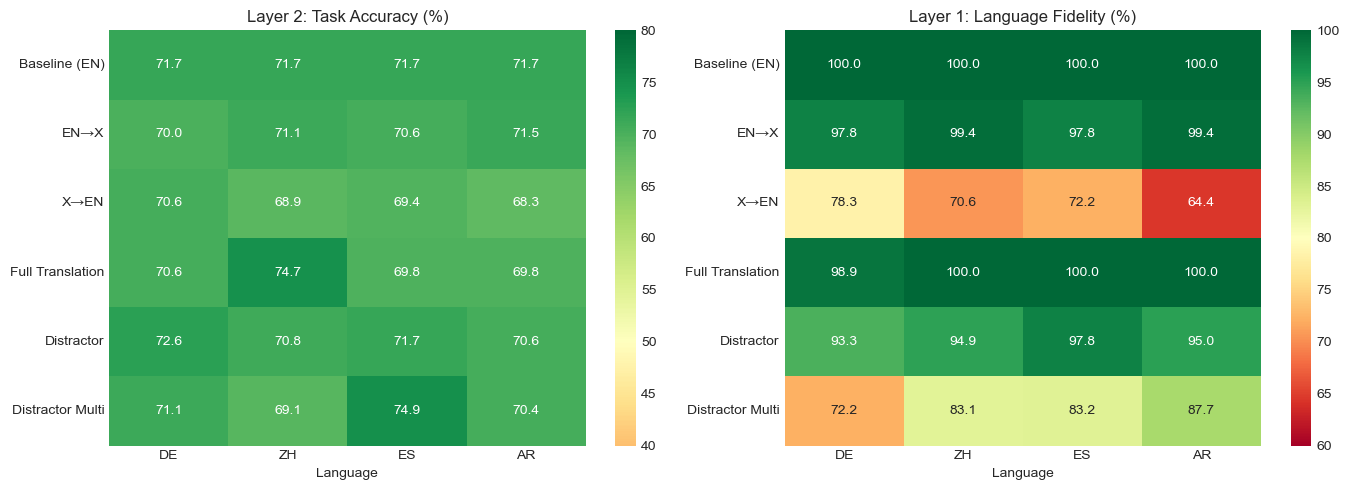

In [6]:
# Heatmap visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for heatmaps (exclude Avg column)
task_hm = task_table.set_index('Condition')[['DE', 'ZH', 'ES', 'AR']]
lang_hm = lang_table.set_index('Condition')[['DE', 'ZH', 'ES', 'AR']]

# Task accuracy heatmap
sns.heatmap(task_hm, annot=True, fmt='.1f', cmap='RdYlGn', center=50, 
            vmin=40, vmax=80, ax=axes[0])
axes[0].set_title('Layer 2: Task Accuracy (%)', fontsize=12)
axes[0].set_xlabel('Language')
axes[0].set_ylabel('')

# Language fidelity heatmap
sns.heatmap(lang_hm, annot=True, fmt='.1f', cmap='RdYlGn', center=80,
            vmin=60, vmax=100, ax=axes[1])
axes[1].set_title('Layer 1: Language Fidelity (%)', fontsize=12)
axes[1].set_xlabel('Language')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../results/gemini-3-pro/analysis_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Failed Response Analysis

In [7]:
# Empty responses analysis
print("=" * 60)
print("EMPTY RESPONSES ANALYSIS")
print("=" * 60)

df_empty = df_eval[df_eval['response_len'] == 0]
print(f"\nTotal empty responses: {len(df_empty)}")

# By condition
print("\nBy condition:")
print(df_empty['condition'].value_counts())

# By axis
print("\nBy axis:")
print(df_empty['axis'].value_counts())

# Most affected questions
print("\nMost affected base question IDs:")
df_empty['base_id'] = df_empty['question_id'].apply(lambda x: x.split('_')[0])
print(df_empty['base_id'].value_counts().head(10))

EMPTY RESPONSES ANALYSIS

Total empty responses: 44

By condition:
condition
distractor_multi         12
distractor               11
codeswitching             9
codeswitching_reverse     8
baseline                  2
full_translation          2
Name: count, dtype: int64

By axis:
axis
INSTRUCTION_RETENTION    39
INFERENCE_MEMORY          5
Name: count, dtype: int64

Most affected base question IDs:
base_id
67456856ff33175f5b310ec3    10
674564fc0c7ee4114a1700e4     9
6765f1c86539ceefe4b7ab4f     6
6765f1c8c745ff4d4ce0a0d5     4
6765f839bdcf6dda476f4dc5     3
674567d0de781b6a4e468bda     2
6781aa5319cf84439e50c457     2
6765fca37d2428f97c0c4759     2
67455268bc2ba9e69b8618f8     1
6745526875828b24787b636f     1
Name: count, dtype: int64


/var/folders/4t/fm4_3xrd5d7d78c65jqr52c00000gn/T/ipykernel_14999/3909084884.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_empty['base_id'] = df_empty['question_id'].apply(lambda x: x.split('_')[0])


In [8]:
# Failed task responses (non-empty but failed)
print("\n" + "=" * 60)
print("FAILED TASK RESPONSES ANALYSIS")
print("=" * 60)

df_failed = df_valid[df_valid['passed'] == False]
print(f"\nTotal failed (non-empty): {len(df_failed)}")

# Failure rate by condition
print("\nFailure rate by condition:")
failure_by_cond = df_valid.groupby('condition')['passed'].apply(lambda x: (1 - x.mean()) * 100).round(1)
print(failure_by_cond.sort_values(ascending=False))

# Failure rate by axis
print("\nFailure rate by axis:")
failure_by_axis = df_valid.groupby('axis')['passed'].apply(lambda x: (1 - x.mean()) * 100).round(1)
print(failure_by_axis)


FAILED TASK RESPONSES ANALYSIS

Total failed (non-empty): 1101

Failure rate by condition:
condition
codeswitching_reverse    30.7
codeswitching            29.2
full_translation         28.8
distractor               28.6
distractor_multi         28.6
baseline                 28.3
Name: passed, dtype: float64

Failure rate by axis:
axis
INFERENCE_MEMORY         23.6
INSTRUCTION_RETENTION    38.4
Name: passed, dtype: float64



Failure rate by condition and axis:
axis                   INFERENCE_MEMORY  INSTRUCTION_RETENTION
condition                                                     
baseline                           21.4                   39.7
codeswitching                      23.5                   38.8
codeswitching_reverse              23.7                   42.4
distractor                         24.2                   36.1
distractor_multi                   25.5                   34.0
full_translation                   21.7                   40.5


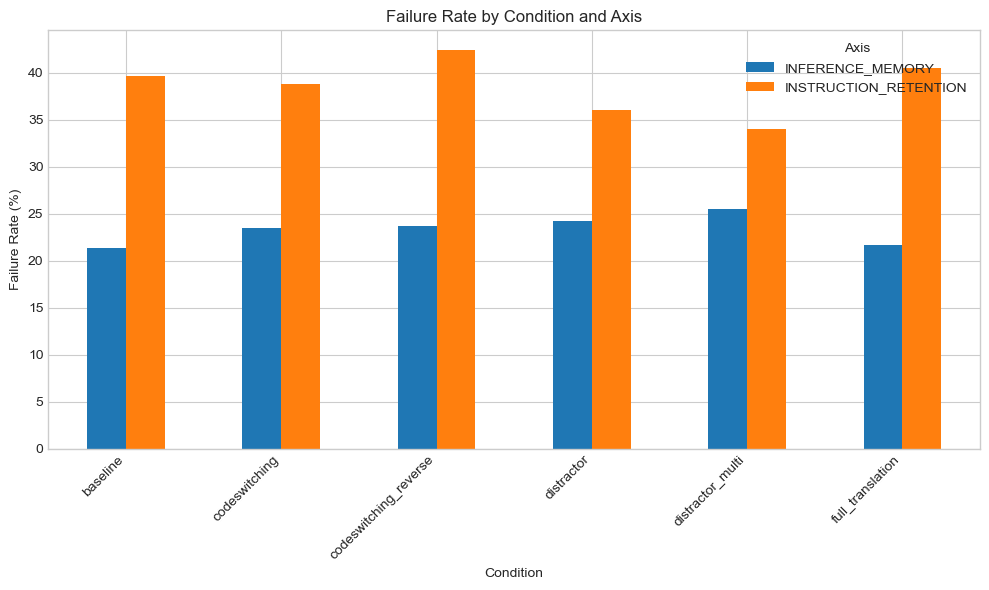

In [9]:
# Failure rate by condition and axis
print("\nFailure rate by condition and axis:")
failure_pivot = df_valid.groupby(['condition', 'axis'])['passed'].apply(lambda x: (1-x.mean())*100).unstack().round(1)
print(failure_pivot)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
failure_pivot.plot(kind='bar', ax=ax)
ax.set_title('Failure Rate by Condition and Axis', fontsize=12)
ax.set_xlabel('Condition')
ax.set_ylabel('Failure Rate (%)')
ax.legend(title='Axis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/gemini-3-pro/failure_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Language fidelity failures
print("\n" + "=" * 60)
print("LANGUAGE FIDELITY FAILURES")
print("=" * 60)

df_lang_fail = df_lang[df_lang['lang_match'] == False]
print(f"\nTotal language mismatches: {len(df_lang_fail)}")

# By condition
print("\nLanguage mismatch by condition:")
mismatch_by_cond = df_lang.groupby('condition')['lang_match'].apply(lambda x: (1 - x.mean()) * 100).round(1)
print(mismatch_by_cond.sort_values(ascending=False))

# Most common mismatches (expected vs detected)
print("\nMost common language confusions:")
confusion = df_lang_fail.groupby(['expected_lang', 'detected_lang']).size().sort_values(ascending=False).head(10)
print(confusion)


LANGUAGE FIDELITY FAILURES

Total language mismatches: 384

Language mismatch by condition:
condition
codeswitching_reverse    28.6
distractor_multi         18.4
distractor                4.7
codeswitching             1.4
full_translation          0.3
baseline                  0.0
Name: lang_match, dtype: float64

Most common language confusions:
expected_lang  detected_lang
en             other            206
de             other             68
zh             other             40
es             other             38
ar             other             32
dtype: int64


## 4. Language-Task Accuracy Correlation

In [11]:
# Merge task and language evaluations
df_merged = df_eval.merge(
    df_lang[['question_id', 'lang_match', 'expected_lang', 'detected_lang']], 
    on='question_id', 
    how='left'
)

# Filter to valid responses
df_merged_valid = df_merged[df_merged['response_len'] > 0]

print("=" * 60)
print("LANGUAGE FIDELITY vs TASK ACCURACY CORRELATION")
print("=" * 60)

LANGUAGE FIDELITY vs TASK ACCURACY CORRELATION


In [12]:
# Task accuracy when language is correct vs incorrect
print("Task accuracy by language fidelity:")
task_by_lang = df_merged_valid.groupby('lang_match')['passed'].mean() * 100
print(f"  Language correct: {task_by_lang.get(True, 0):.1f}%")
print(f"  Language incorrect: {task_by_lang.get(False, 0):.1f}%")

# Overall chi-square test (all data points)
from scipy import stats
contingency = pd.crosstab(df_merged_valid['lang_match'], df_merged_valid['passed'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"\nOverall Chi-square test (n={len(df_merged_valid)}):")
print(f"  chi2={chi2:.2f}, p={p:.4f}")
if p < 0.05:
    print("  → Significant relationship between language fidelity and task accuracy")
else:
    print("  → No significant relationship")

# Per-language chi-square tests (Bonferroni correction: α=0.05/4=0.0125)
print("\n" + "-" * 60)
print("Per-language chi-square tests (Bonferroni α=0.0125):")
print("-" * 60)

lang_results = []
for lang in ['de', 'zh', 'es', 'ar']:
    df_l = df_merged_valid[df_merged_valid['language'] == lang]
    if len(df_l) > 0:
        cont = pd.crosstab(df_l['lang_match'], df_l['passed'])
        if cont.shape == (2, 2):
            chi2_l, p_l, _, _ = stats.chi2_contingency(cont)
            n_correct = (df_l['lang_match'] == True).sum()
            n_wrong = (df_l['lang_match'] == False).sum()
            acc_correct = df_l[df_l['lang_match'] == True]['passed'].mean() * 100
            acc_wrong = df_l[df_l['lang_match'] == False]['passed'].mean() * 100
            sig = "**" if p_l < 0.0125 else ""
            lang_results.append({
                'Lang': lang.upper(),
                'N(Correct)': n_correct,
                'N(Wrong)': n_wrong,
                'Acc(Correct)': acc_correct,
                'Acc(Wrong)': acc_wrong,
                'chi2': chi2_l,
                'p': p_l,
                'Sig': sig
            })

df_lang_tests = pd.DataFrame(lang_results)
print(df_lang_tests.round(3).to_string(index=False))

Task accuracy by language fidelity:
  Language correct: 71.2%
  Language incorrect: 68.9%



Overall Chi-square test (n=5194):
  chi2=1.13, p=0.2869
  → No significant relationship

------------------------------------------------------------
Per-language chi-square tests (Bonferroni α=0.0125):
------------------------------------------------------------


Lang  N(Correct)  N(Wrong)  Acc(Correct)  Acc(Wrong)  chi2     p Sig
  DE        1089       166        71.534      69.277 0.256 0.613    
  ZH        1119       131        71.314      64.885 2.037 0.154    
  ES        1135       120        71.630      74.167 0.231 0.631    
  AR        1130       124        70.442      67.742 0.271 0.603    

In [13]:
# Logistic regression: controls for condition and language
import statsmodels.api as sm
from statsmodels.formula.api import logit

print("=" * 60)
print("LOGISTIC REGRESSION: passed ~ lang_match + condition + language")
print("=" * 60)

# Prepare data (exclude baseline - no language variation)
df_model = df_merged_valid[df_merged_valid['condition'] != 'baseline'].copy()
df_model['lang_match_int'] = df_model['lang_match'].astype(int)
df_model['passed_int'] = df_model['passed'].astype(int)

# Fit model
model = logit('passed_int ~ lang_match_int + C(condition) + C(language)', data=df_model).fit(disp=0)

# Show key results
print(f"\nModel: n={len(df_model)}, Pseudo R²={model.prsquared:.4f}")
print("\nKey coefficient:")
print("-" * 60)

coef = model.params['lang_match_int']
se = model.bse['lang_match_int']
pval = model.pvalues['lang_match_int']
odds_ratio = np.exp(coef)
ci_low = np.exp(coef - 1.96 * se)
ci_high = np.exp(coef + 1.96 * se)

print(f"  lang_match: β={coef:.3f}, SE={se:.3f}, p={pval:.4f}")
print(f"  Odds Ratio: {odds_ratio:.3f} (95% CI: {ci_low:.3f}-{ci_high:.3f})")

if pval < 0.05:
    print("\n  → SIGNIFICANT: Language fidelity affects task accuracy")
else:
    print("\n  → NOT SIGNIFICANT: Language fidelity does not affect task accuracy")
    print(f"     (controlling for condition and language)")

LOGISTIC REGRESSION: passed ~ lang_match + condition + language



Model: n=5014, Pseudo R²=0.0005

Key coefficient:
------------------------------------------------------------
  lang_match: β=0.096, SE=0.103, p=0.3528
  Odds Ratio: 1.100 (95% CI: 0.899-1.347)

  → NOT SIGNIFICANT: Language fidelity does not affect task accuracy
     (controlling for condition and language)


In [14]:
# Per condition × language breakdown
print("=" * 80)
print("TASK ACCURACY BY LANGUAGE FIDELITY: CONDITION × LANGUAGE")
print("=" * 80)

results = []
for cond in ['codeswitching', 'codeswitching_reverse', 'full_translation', 'distractor', 'distractor_multi']:
    for lang in ['de', 'zh', 'es', 'ar']:
        df_cl = df_merged_valid[(df_merged_valid['condition'] == cond) & (df_merged_valid['language'] == lang)]
        if len(df_cl) == 0:
            continue
        
        n_correct = (df_cl['lang_match'] == True).sum()
        n_wrong = (df_cl['lang_match'] == False).sum()
        
        acc_correct = df_cl[df_cl['lang_match'] == True]['passed'].mean() * 100 if n_correct > 0 else np.nan
        acc_wrong = df_cl[df_cl['lang_match'] == False]['passed'].mean() * 100 if n_wrong > 0 else np.nan
        
        diff = acc_correct - acc_wrong if not (np.isnan(acc_correct) or np.isnan(acc_wrong)) else np.nan
        
        # Chi-square if both groups have data
        p_val = np.nan
        if n_correct > 0 and n_wrong > 0:
            cont = pd.crosstab(df_cl['lang_match'], df_cl['passed'])
            if cont.shape == (2, 2):
                _, p_val, _, _ = stats.chi2_contingency(cont)
        
        results.append({
            'Condition': condition_labels.get(cond, cond),
            'Lang': lang.upper(),
            'N(✓)': n_correct,
            'N(✗)': n_wrong,
            'Acc(✓)': acc_correct,
            'Acc(✗)': acc_wrong,
            'Δ': diff,
            'p': p_val
        })

df_cond_lang = pd.DataFrame(results)
print(df_cond_lang.round(1).to_string(index=False))

# Pivot tables
print("\n" + "=" * 60)
print("Difference in Task Acc (Lang Correct - Lang Wrong):")
print("=" * 60)
pivot_diff = df_cond_lang.pivot(index='Condition', columns='Lang', values='Δ')
print(pivot_diff.round(1))
print("\nNote: Positive = better task acc when language is correct")
print("      NaN = no wrong-language cases for that cell")

TASK ACCURACY BY LANGUAGE FIDELITY: CONDITION × LANGUAGE
       Condition Lang  N(✓)  N(✗)  Acc(✓)  Acc(✗)     Δ   p
            EN→X   DE   176     4    69.9    75.0  -5.1 1.0
            EN→X   ZH   179     1    70.9   100.0 -29.1 1.0
            EN→X   ES   176     4    70.5    75.0  -4.5 1.0
            EN→X   AR   178     1    71.3   100.0 -28.7 1.0
            X→EN   DE   141    39    72.3    64.1   8.2 0.4
            X→EN   ZH   127    53    70.1    66.0   4.0 0.7
            X→EN   ES   130    50    68.5    72.0  -3.5 0.8
            X→EN   AR   116    64    67.2    70.3  -3.1 0.8
Full Translation   DE   178     2    70.8    50.0  20.8 1.0
Full Translation   ZH   182     0    74.7     NaN   NaN NaN
Full Translation   ES   182     0    69.8     NaN   NaN NaN
Full Translation   AR   182     0    69.8     NaN   NaN NaN
      Distractor   DE   297    60    72.4    73.3  -0.9 1.0
      Distractor   ZH   316    38    71.8    63.2   8.7 0.4
      Distractor   ES   324    33    71.9  

In [15]:
# Correlation by condition (excluding baseline - it has no language variation)
print("\nTask accuracy by language fidelity (per condition):")
print("-" * 70)

results = []
for cond in df_merged_valid['condition'].unique():
    if cond == 'baseline':
        continue  # Skip baseline - no language variation
    
    df_cond = df_merged_valid[df_merged_valid['condition'] == cond]
    
    lang_correct = df_cond[df_cond['lang_match'] == True]['passed'].mean() * 100
    lang_incorrect = df_cond[df_cond['lang_match'] == False]['passed'].mean() * 100
    
    n_correct = (df_cond['lang_match'] == True).sum()
    n_incorrect = (df_cond['lang_match'] == False).sum()
    
    results.append({
        'Condition': condition_labels.get(cond, cond),
        'Task Acc (Lang Correct)': lang_correct,
        'Task Acc (Lang Wrong)': lang_incorrect,
        'N (Correct)': n_correct,
        'N (Wrong)': n_incorrect,
        'Diff': lang_correct - lang_incorrect if not np.isnan(lang_incorrect) else np.nan
    })

df_corr = pd.DataFrame(results)
print(df_corr.round(1).to_string(index=False))


Task accuracy by language fidelity (per condition):
----------------------------------------------------------------------
       Condition  Task Acc (Lang Correct)  Task Acc (Lang Wrong)  N (Correct)  N (Wrong)  Diff
      Distractor                     71.7                   69.6         1264        161   2.1
Distractor Multi                     71.7                   68.5         1262        162   3.2
            X→EN                     69.6                   68.4          514        206   1.2
Full Translation                     71.3                   50.0          724          2  21.3
            EN→X                     70.7                   80.0          709         10  -9.3


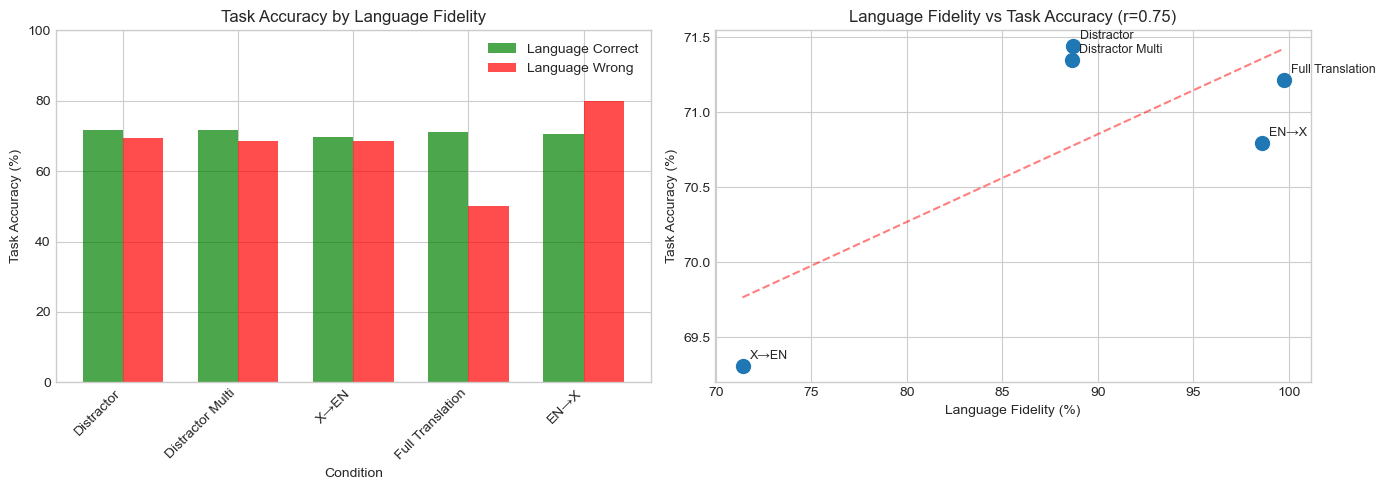

In [16]:
# Visualize correlation (excluding baseline)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparing task accuracy
df_corr_plot = df_corr.dropna(subset=['Diff'])
x = np.arange(len(df_corr_plot))
width = 0.35

axes[0].bar(x - width/2, df_corr_plot['Task Acc (Lang Correct)'], width, label='Language Correct', color='green', alpha=0.7)
axes[0].bar(x + width/2, df_corr_plot['Task Acc (Lang Wrong)'], width, label='Language Wrong', color='red', alpha=0.7)
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Task Accuracy (%)')
axes[0].set_title('Task Accuracy by Language Fidelity')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_corr_plot['Condition'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 100)

# Scatter plot: aggregated by condition (excluding baseline)
df_nonbaseline = df_merged_valid[df_merged_valid['condition'] != 'baseline']
cond_agg = df_nonbaseline.groupby('condition').agg({
    'lang_match': 'mean',
    'passed': 'mean'
}) * 100

axes[1].scatter(cond_agg['lang_match'].astype(float), cond_agg['passed'].astype(float), s=100)
for cond in cond_agg.index:
    axes[1].annotate(condition_labels.get(cond, cond), 
                     (float(cond_agg.loc[cond, 'lang_match']), float(cond_agg.loc[cond, 'passed'])),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)

# Fit line
if len(cond_agg) > 1:
    x_vals = cond_agg['lang_match'].astype(float).values
    y_vals = cond_agg['passed'].astype(float).values
    z = np.polyfit(x_vals, y_vals, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
    axes[1].plot(x_line, p(x_line), 'r--', alpha=0.5)
    corr = np.corrcoef(x_vals, y_vals)[0, 1]
else:
    corr = np.nan

axes[1].set_xlabel('Language Fidelity (%)')
axes[1].set_ylabel('Task Accuracy (%)')
axes[1].set_title(f'Language Fidelity vs Task Accuracy (r={corr:.2f})')

plt.tight_layout()
plt.savefig('../results/gemini-3-pro/lang_task_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Per-question correlation
print("\n" + "=" * 60)
print("PER-QUESTION ANALYSIS")
print("=" * 60)

# Questions that fail both language and task
both_fail = df_merged_valid[(df_merged_valid['lang_match'] == False) & (df_merged_valid['passed'] == False)]
print(f"\nQuestions failing both language AND task: {len(both_fail)}")

# Questions that pass task despite wrong language
wrong_lang_pass_task = df_merged_valid[(df_merged_valid['lang_match'] == False) & (df_merged_valid['passed'] == True)]
print(f"Questions passing task despite wrong language: {len(wrong_lang_pass_task)}")

# Questions that fail task despite correct language
correct_lang_fail_task = df_merged_valid[(df_merged_valid['lang_match'] == True) & (df_merged_valid['passed'] == False)]
print(f"Questions failing task despite correct language: {len(correct_lang_fail_task)}")


PER-QUESTION ANALYSIS

Questions failing both language AND task: 168
Questions passing task despite wrong language: 373
Questions failing task despite correct language: 1338


## 5. Summary Statistics

In [18]:
print("=" * 60)
print("GEMINI 3 PRO - SUMMARY")
print("=" * 60)

# Find best/worst from tables (excluding baseline for comparison)
task_nonbaseline = task_table[task_table['Condition'] != 'Baseline (EN)']
lang_nonbaseline = lang_table[lang_table['Condition'] != 'Baseline (EN)']

best_task_cond = task_nonbaseline.loc[task_nonbaseline['Avg'].idxmax(), 'Condition']
best_task_val = task_nonbaseline['Avg'].max()
worst_task_cond = task_nonbaseline.loc[task_nonbaseline['Avg'].idxmin(), 'Condition']
worst_task_val = task_nonbaseline['Avg'].min()

best_lang_cond = lang_nonbaseline.loc[lang_nonbaseline['Avg'].idxmax(), 'Condition']
best_lang_val = lang_nonbaseline['Avg'].max()
worst_lang_cond = lang_nonbaseline.loc[lang_nonbaseline['Avg'].idxmin(), 'Condition']
worst_lang_val = lang_nonbaseline['Avg'].min()

baseline_task = task_table[task_table['Condition'] == 'Baseline (EN)']['Avg'].values[0]
baseline_lang = lang_table[lang_table['Condition'] == 'Baseline (EN)']['Avg'].values[0]

print(f"""
Total evaluations: {total}
Empty responses: {empty} ({empty/total*100:.1f}%)
Valid responses: {valid}

LAYER 2 (Task Accuracy):
  Baseline: {baseline_task:.1f}%
  Best: {best_task_cond} ({best_task_val:.1f}%)
  Worst: {worst_task_cond} ({worst_task_val:.1f}%)

LAYER 1 (Language Fidelity):
  Baseline: {baseline_lang:.1f}%
  Best: {best_lang_cond} ({best_lang_val:.1f}%)
  Worst: {worst_lang_cond} ({worst_lang_val:.1f}%)

KEY FINDINGS:
  - X→EN has worst language fidelity: model responds in context language
  - Task accuracy is stable across conditions (max {baseline_task - worst_task_val:.1f}% drop)
""")

GEMINI 3 PRO - SUMMARY

Total evaluations: 3822
Empty responses: 44 (1.2%)
Valid responses: 3778

LAYER 2 (Task Accuracy):
  Baseline: 71.7%
  Best: Distractor (71.4%)
  Worst: X→EN (69.3%)

LAYER 1 (Language Fidelity):
  Baseline: 100.0%
  Best: Full Translation (99.7%)
  Worst: X→EN (71.4%)

KEY FINDINGS:
  - X→EN has worst language fidelity: model responds in context language
  - Task accuracy is stable across conditions (max 2.4% drop)

